In [6]:
# Dependency imports
import os
import zipfile
import requests
import random
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict

In [ ]:
# Download the PlantVillage dataset zip file

url = "https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/d5652a28-c1d8-4b76-97f3-72fb80f94efc/file_downloaded"
headers = {"User-Agent": "Mozilla/5.0"}
response = requests.get(url, headers=headers)

if response.status_code == 200:
    with open("plantvillage.zip", "wb") as f:
        f.write(response.content)
    print("Download complete!")
else:
    print(f"Download failed! HTTP {response.status_code}")

In [ ]:
# Extraction dataset zip file

zip_path = "plantvillage.zip"
extract_dir = "./plantvillage"

# Extract the dataset
if not os.path.exists(extract_dir):
    print("Extracting dataset...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_dir)
    print("Extraction complete!")
else:
    print("Folder already exists, skipping extraction.")

# Path to the actual dataset folder (update if needed)
dataset_root = './plantvillage/Plant_leave_diseases_dataset_without_augmentation'

# List plant disease categories
print("\n🌿 Plant Disease Categories:")
if os.path.exists(dataset_root):
    for disease_folder in sorted(os.listdir(dataset_root)):
        if os.path.isdir(os.path.join(dataset_root, disease_folder)):
            print(f"- {disease_folder}")
else:
    print("Dataset path not found! Check extraction folder structure.")


In [12]:
# Create balanced dataset directory

original_dir = './plantvillage/Plant_leave_diseases_dataset_without_augmentation'
balanced_dir = './plantvillage_balanced'
os.makedirs(balanced_dir, exist_ok=True)

# Image augmentation settings
datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Count images per class
class_counts = {
    cls: len(os.listdir(os.path.join(original_dir, cls)))
    for cls in os.listdir(original_dir)
    if os.path.isdir(os.path.join(original_dir, cls))
}

max_count = max(class_counts.values())
print(f"Maximum images per class = {max_count}")

# Balance all classes
for cls in sorted(os.listdir(original_dir)):
    cls_path = os.path.join(original_dir, cls)
    if not os.path.isdir(cls_path):
        continue

    imgs = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    cls_bal_dir = os.path.join(balanced_dir, cls)
    os.makedirs(cls_bal_dir, exist_ok=True)

    # Copy original images
    for img in imgs:
        shutil.copy(os.path.join(cls_path, img), os.path.join(cls_bal_dir, img))

    # Generate augmented images
    i = 0
    while len(os.listdir(cls_bal_dir)) < max_count:
        img_name = random.choice(imgs)
        img_path = os.path.join(cls_path, img_name)
        img = Image.open(img_path).convert('RGB').resize((300, 300))
        x = np.expand_dims(np.array(img) / 255.0, axis=0)
        aug_img = next(datagen.flow(x, batch_size=1))[0]
        aug_img = Image.fromarray((aug_img * 255).astype(np.uint8))
        aug_img.save(os.path.join(cls_bal_dir, f"aug_{i}_{img_name}"))
        i += 1

print("Balanced dataset created at:", balanced_dir)


Maximum images per class = 5507
Balanced dataset created at: ./plantvillage_balanced


In [13]:
# Split balanced dataset into train, val, test

# Paths
balanced_dir = './plantvillage_balanced'
split_dir = './plantvillage_split'
os.makedirs(split_dir, exist_ok=True)

# Split ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Function to create split directories
def make_dirs(base_dir, cls):
    train_cls = os.path.join(base_dir, 'train', cls)
    val_cls = os.path.join(base_dir, 'val', cls)
    test_cls = os.path.join(base_dir, 'test', cls)
    os.makedirs(train_cls, exist_ok=True)
    os.makedirs(val_cls, exist_ok=True)
    os.makedirs(test_cls, exist_ok=True)
    return train_cls, val_cls, test_cls

# Loop through each class and split
for cls in sorted(os.listdir(balanced_dir)):
    cls_path = os.path.join(balanced_dir, cls)
    if not os.path.isdir(cls_path):
        continue

    images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(images)

    n_total = len(images)
    n_train = int(train_ratio * n_total)
    n_val = int(val_ratio * n_total)
    # Remaining goes to test
    n_test = n_total - n_train - n_val

    train_cls, val_cls, test_cls = make_dirs(split_dir, cls)

    # Copy images to respective folders
    for i, img in enumerate(images):
        src = os.path.join(cls_path, img)
        if i < n_train:
            dst = os.path.join(train_cls, img)
        elif i < n_train + n_val:
            dst = os.path.join(val_cls, img)
        else:
            dst = os.path.join(test_cls, img)
        shutil.copy(src, dst)

print("Dataset split into train, val, test at:", split_dir)

Dataset split into train, val, test at: ./plantvillage_split


Detected 39 classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___To

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 39)             │        10,023 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,387,530 (16.74 MB)

 Trainable params: 1,119,399 (4.27 MB)

 Non-trainable params: 3,268,131 (12.47 MB)

Epoch 1/10
4698/4698 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8993 - loss: 0.3416
Epoch 1: val_accuracy improved from None to 0.97559, saving model to efficientnet_plantvillage_best.h5


4698/4698 ━━━━━━━━━━━━━━━━━━━━ 7888s 2s/step - accuracy: 0.9454 - loss: 0.1719 - val_accuracy: 0.9756 - val_loss: 0.0772 - learning_rate: 0.0010
Epoch 2/10
4698/4698 ━━━━━━━━━━━━━━━━━━━━ 0s 861ms/step - accuracy: 0.9729 - loss: 0.0808
Epoch 2: val_accuracy improved from 0.97559 to 0.98773, saving model to efficientnet_plantvillage_best.h5


4698/4698 ━━━━━━━━━━━━━━━━━━━━ 5089s 1s/step - accuracy: 0.9744 - loss: 0.0774 - val_accuracy: 0.9877 - val_loss: 0.0349 - learning_rate: 0.0010
Epoch 3/10
4698/4698 ━━━━━━━━━━━━━━━━━━━━ 0s 861ms/step - accuracy: 0.9796 - loss: 0.0620
Epoch 3: val_accuracy improved from 0.98773 to 0.98987, saving model to efficientnet_plantvillage_best.h5


4698/4698 ━━━━━━━━━━━━━━━━━━━━ 5086s 1s/step - accuracy: 0.9794 - loss: 0.0620 - val_accuracy: 0.9899 - val_loss: 0.0306 - learning_rate: 0.0010
Epoch 4/10
4698/4698 ━━━━━━━━━━━━━━━━━━━━ 0s 871ms/step - accuracy: 0.9832 - loss: 0.0519
Epoch 4: val_accuracy improved from 0.98987 to 0.99080, saving model to efficientnet_plantvillage_best.h5


4698/4698 ━━━━━━━━━━━━━━━━━━━━ 5160s 1s/step - accuracy: 0.9836 - loss: 0.0513 - val_accuracy: 0.9908 - val_loss: 0.0264 - learning_rate: 0.0010
Epoch 5/10
4698/4698 ━━━━━━━━━━━━━━━━━━━━ 0s 868ms/step - accuracy: 0.9851 - loss: 0.0473
Epoch 5: val_accuracy improved from 0.99080 to 0.99229, saving model to efficientnet_plantvillage_best.h5


4698/4698 ━━━━━━━━━━━━━━━━━━━━ 5120s 1s/step - accuracy: 0.9851 - loss: 0.0469 - val_accuracy: 0.9923 - val_loss: 0.0219 - learning_rate: 0.0010
Epoch 6/10
4698/4698 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - accuracy: 0.9873 - loss: 0.0398
Epoch 6: val_accuracy improved from 0.99229 to 0.99262, saving model to efficientnet_plantvillage_best.h5


4698/4698 ━━━━━━━━━━━━━━━━━━━━ 5096s 1s/step - accuracy: 0.9870 - loss: 0.0406 - val_accuracy: 0.9926 - val_loss: 0.0227 - learning_rate: 0.0010
Epoch 7/10
4698/4698 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.9876 - loss: 0.0392
Epoch 7: val_accuracy improved from 0.99262 to 0.99339, saving model to efficientnet_plantvillage_best.h5


4698/4698 ━━━━━━━━━━━━━━━━━━━━ 5082s 1s/step - accuracy: 0.9877 - loss: 0.0395 - val_accuracy: 0.9934 - val_loss: 0.0220 - learning_rate: 0.0010
Epoch 8/10
4698/4698 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.9892 - loss: 0.0345
Epoch 8: val_accuracy improved from 0.99339 to 0.99578, saving model to efficientnet_plantvillage_best.h5


4698/4698 ━━━━━━━━━━━━━━━━━━━━ 5081s 1s/step - accuracy: 0.9890 - loss: 0.0357 - val_accuracy: 0.9958 - val_loss: 0.0155 - learning_rate: 0.0010
Epoch 9/10
4698/4698 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.9905 - loss: 0.0314
Epoch 9: val_accuracy did not improve from 0.99578
4698/4698 ━━━━━━━━━━━━━━━━━━━━ 5081s 1s/step - accuracy: 0.9898 - loss: 0.0338 - val_accuracy: 0.9948 - val_loss: 0.0165 - learning_rate: 0.0010
Epoch 10/10
4698/4698 ━━━━━━━━━━━━━━━━━━━━ 0s 862ms/step - accuracy: 0.9903 - loss: 0.0317
Epoch 10: val_accuracy did not improve from 0.99578
4698/4698 ━━━━━━━━━━━━━━━━━━━━ 5090s 1s/step - accuracy: 0.9901 - loss: 0.0331 - val_accuracy: 0.9940 - val_loss: 0.0249 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 8.


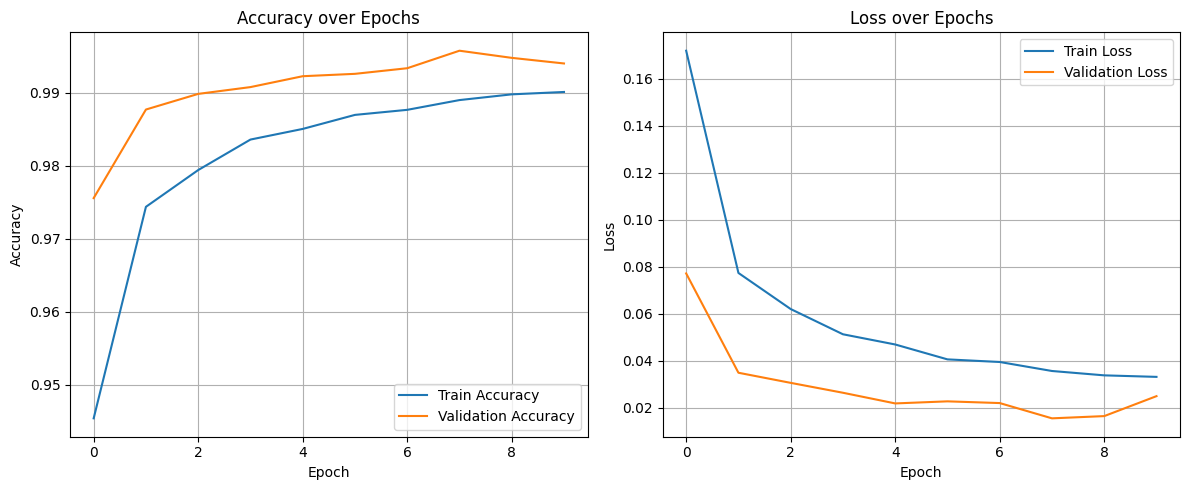

673/673 ━━━━━━━━━━━━━━━━━━━━ 751s 1s/step - accuracy: 0.9956 - loss: 0.0140

✅ Test Accuracy: 0.9956
673/673 ━━━━━━━━━━━━━━━━━━━━ 534s 787ms/step


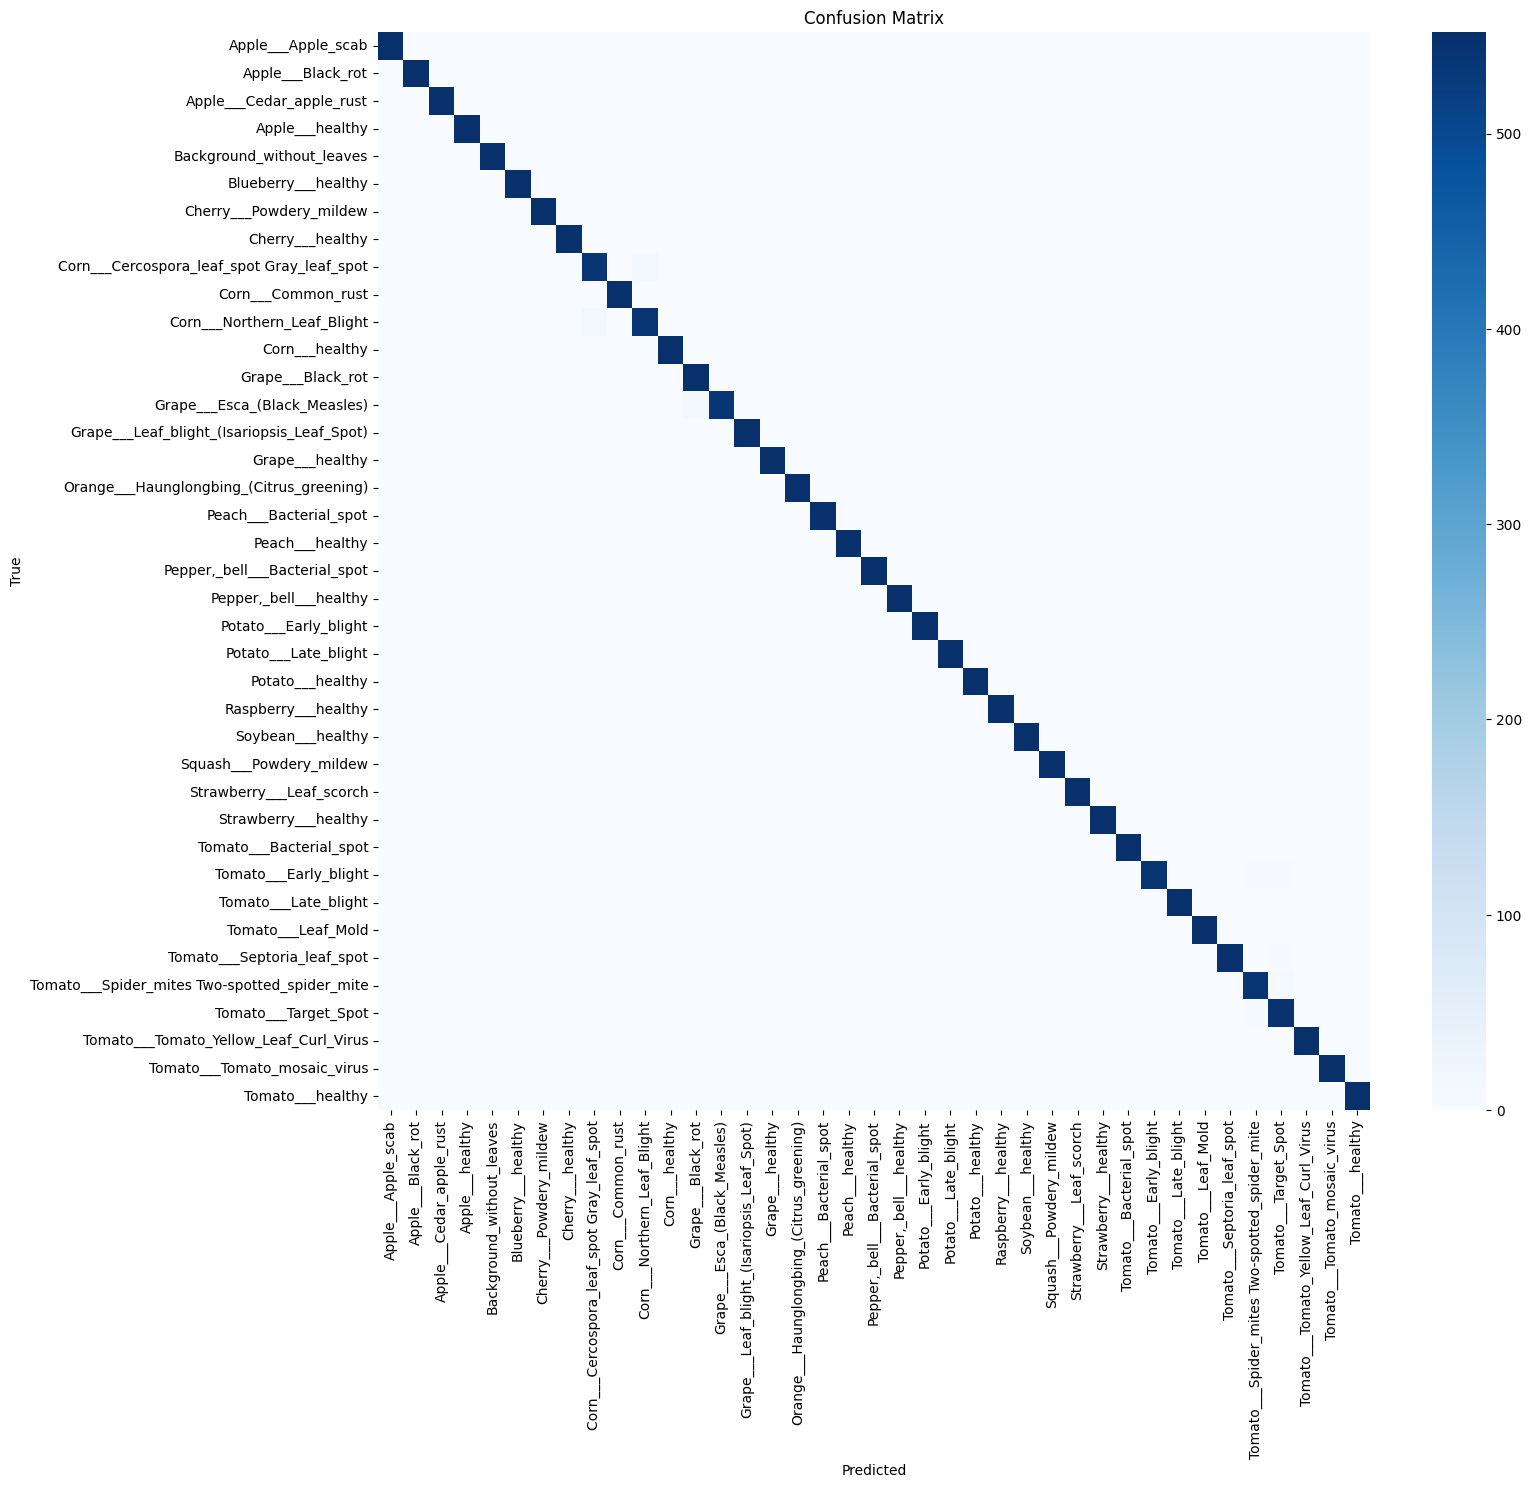

✅ Classification Report:

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       1.00      1.00      1.00       552
                            Apple___Black_rot       1.00      1.00      1.00       552
                     Apple___Cedar_apple_rust       1.00      1.00      1.00       552
                              Apple___healthy       1.00      0.99      1.00       552
                    Background_without_leaves       1.00      1.00      1.00       552
                          Blueberry___healthy       1.00      1.00      1.00       552
                      Cherry___Powdery_mildew       1.00      1.00      1.00       552
                             Cherry___healthy       1.00      1.00      1.00       552
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.98      0.98      0.98       552
                           Corn___Common_rust       1.00      1.00      1.00       552
                

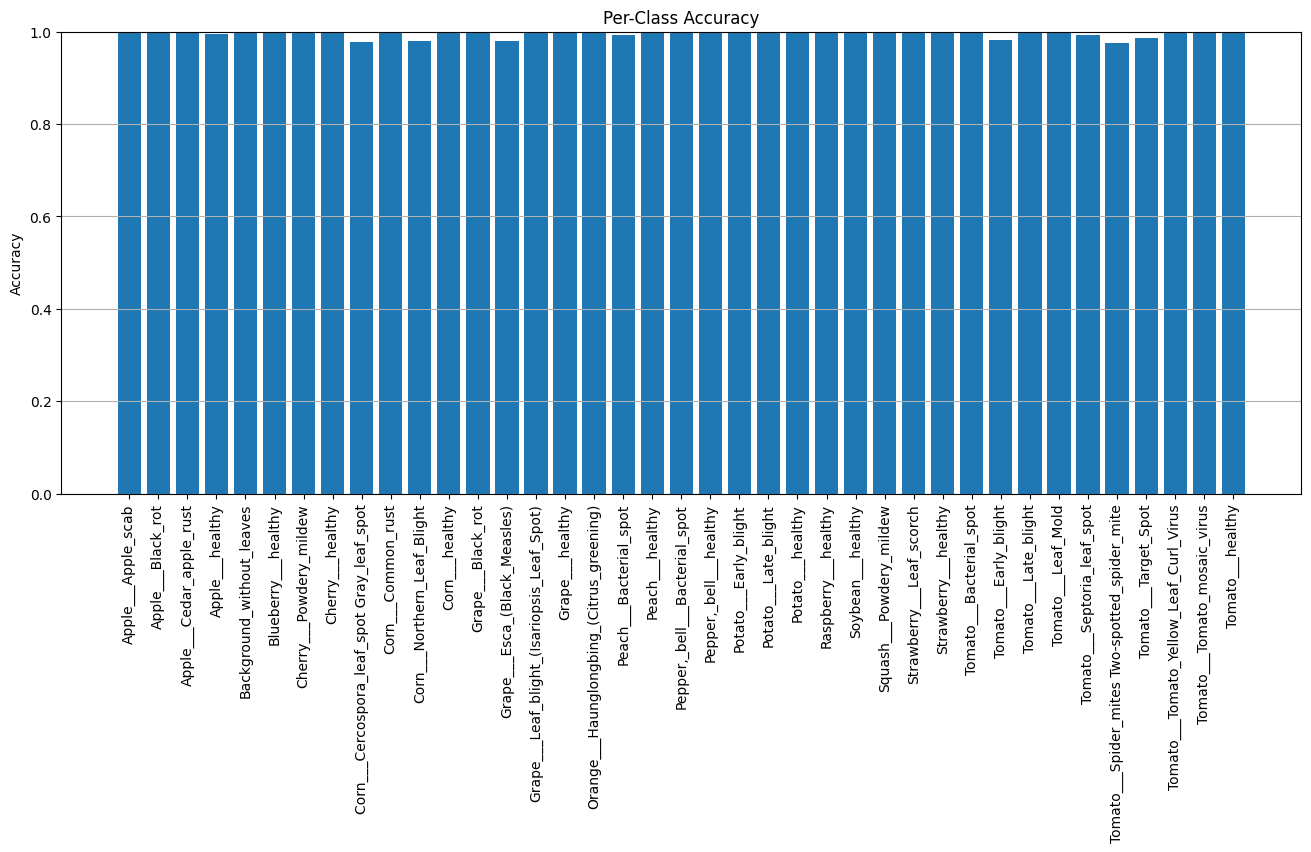

✅ Per-Class Accuracy:

Tomato___Spider_mites Two-spotted_spider_mite: 0.9746
Corn___Cercospora_leaf_spot Gray_leaf_spot: 0.9764
Corn___Northern_Leaf_Blight: 0.9801
Grape___Esca_(Black_Measles): 0.9801
Tomato___Early_blight: 0.9819
Tomato___Target_Spot: 0.9855
Peach___Bacterial_spot: 0.9928
Tomato___Septoria_leaf_spot: 0.9928
Apple___healthy: 0.9946
Apple___Apple_scab: 0.9964
Background_without_leaves: 0.9964
Pepper,_bell___Bacterial_spot: 0.9964
Tomato___Late_blight: 0.9964
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 0.9964
Peach___healthy: 0.9982
Potato___Late_blight: 0.9982
Raspberry___healthy: 0.9982
Soybean___healthy: 0.9982
Tomato___Leaf_Mold: 0.9982
Tomato___healthy: 0.9982
Apple___Black_rot: 1.0000
Apple___Cedar_apple_rust: 1.0000
Blueberry___healthy: 1.0000
Cherry___Powdery_mildew: 1.0000
Cherry___healthy: 1.0000
Corn___Common_rust: 1.0000
Corn___healthy: 1.0000
Grape___Black_rot: 1.0000
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1.0000
Grape___healthy: 1.0000
Orange___Haunglongbi

In [ ]:
# Model Training and Evaluation Script

# ======================
# === Parameters =======
# ======================
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 32
NUM_EPOCHS = 5
NUM_TRAINABLE_LAYERS = 3  # last N layers to fine-tune (0 = no fine-tuning)
LEARNING_RATE = 1e-3

# ======================
# === Dataset Paths ====
# ======================
TRAIN_DATA_DIR = "./plantvillage_split/train"
VALIDATION_DATA_DIR = "./plantvillage_split/val"
TEST_DATA_DIR = "./plantvillage_split/test"

# ======================
# === Dynamic Class Detection ===
# ======================
class_labels = sorted([d for d in os.listdir(TRAIN_DATA_DIR) 
                       if os.path.isdir(os.path.join(TRAIN_DATA_DIR, d))])
NUM_CLASSES = len(class_labels)
print(f"Detected {NUM_CLASSES} classes: {class_labels}")

# ======================
# === Data Generators ===
# ======================
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

validation_generator = val_test_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# ======================
# === Build Model ======
# ======================
base_model = EfficientNetB0(weights='imagenet', include_top=False,
                            input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
base_model.summary()

# Freeze all layers
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze last N layers for fine-tuning
if NUM_TRAINABLE_LAYERS > 0:
    for layer in base_model.layers[-NUM_TRAINABLE_LAYERS:]:
        layer.trainable = True

# Build the full model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(NUM_CLASSES, activation='softmax')
])

# ======================
# === Compile Model ====
# ======================
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

# ======================
# === Callbacks ========
# ======================
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                         patience=3, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                     restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ModelCheckpoint("efficientnet_plantvillage_best.h5",
                                       monitor='val_accuracy',
                                       save_best_only=True, verbose=1)
]

# ======================
# === Train Model ======
# ======================
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=NUM_EPOCHS,
    callbacks=callbacks
)

# ======================
# === Plot Training History ===
# ======================
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

# ======================
# === Evaluate Model ===
# ======================
loss, accuracy = model.evaluate(test_generator)
print(f"\n✅ Test Accuracy: {accuracy:.4f}")

# ======================
# === Confusion Matrix ===
# ======================
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ======================
# === Classification Report ===
# ======================
report = classification_report(y_true, y_pred, target_names=class_labels)
print("✅ Classification Report:\n")
print(report)

# ======================
# === Per-Class Accuracy ===
# ======================
class_correct = defaultdict(int)
class_total = defaultdict(int)

for true, pred in zip(y_true, y_pred):
    class_total[class_labels[true]] += 1
    if true == pred:
        class_correct[class_labels[true]] += 1

per_class_accuracy = {cls: class_correct[cls] / class_total[cls] for cls in class_labels}

# Plot per-class accuracy
plt.figure(figsize=(16,6))
plt.bar(per_class_accuracy.keys(), per_class_accuracy.values())
plt.xticks(rotation=90)
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

# Optional: print per-class accuracy sorted
print("✅ Per-Class Accuracy:\n")
for cls, acc in sorted(per_class_accuracy.items(), key=lambda x: x[1]):
    print(f"{cls}: {acc:.4f}")

# ======================
# === Save Model =======
# ======================
model.save("efficientnet_plantvillage_final.h5")


In [6]:
# Loading model for testing 

def predict_image_with_percentages(img_path, model, class_names):
    # Load and preprocess
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Predict
    preds = model.predict(img_array)[0]

    # Print results
    print("\n========= Prediction Result =========")
    for cls, prob in zip(class_names, preds):
        print(f"{cls:25s} : {prob*100:.2f}%")

    predicted_class = class_names[np.argmax(preds)]
    confidence = np.max(preds) * 100

    print("\nMost Likely Class:", predicted_class)
    print(f"Confidence: {confidence:.2f}%")

    return predicted_class, preds

In [1]:
model = tf.keras.models.load_model("efficientnet_plantvillage_final.h5")
print("Model loaded successfully!")

# Load class names
TEST_DATA_DIR = "./plantvillage/Plant_leave_diseases_dataset_without_augmentation"
class_names = sorted(os.listdir(TEST_DATA_DIR))

# Predict
predict_image_with_percentages("real_time_testing/images2.jpg", model, class_names)



NameError: name 'tf' is not defined